<a href="https://colab.research.google.com/github/mnslarcher/cs224w-slides-to-code/blob/main/notebooks/03-node-embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color='red'>Disclaimer: this notebook is still a work in progress</font>

# Node Embeddings

In [1]:
import random
import time
from typing import Optional, Tuple

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from IPython.display import clear_output, display

In [2]:
def seed_everything(seed: Optional[int] = None) -> None:
    random.seed(seed)
    np.random.seed(seed)


seed_everything(42)

# Random Walk

In [3]:
class RandomWalk:
    def __init__(
        self,
        G: nx.Graph,
        node_size: int = 1500,
        width: int = 2,
        font_size: int = 16,
        fig_size: Tuple[int, int] = (8, 6),
        seed: int = 42,
    ) -> None:
        self.G = G
        self.node_size = node_size
        self.width = width
        self.font_size = font_size
        self.fig_size = fig_size
        self.seed = seed

    def _draw(self, ax: plt.Axes) -> None:
        node_colors = [
            "tab:blue"
            if node == self.current_node
            else "tab:red"
            if node == self.starting_node
            else "tab:gray"
            if node in self.visited_nodes
            else "white"
            for node in self.G.nodes
        ]
        edge_colors = ["tab:gray" if sorted(edge) in self.visited_edges else "black" for edge in self.G.edges]
        pos = nx.spring_layout(self.G, seed=self.seed)

        nx.draw(
            self.G,
            pos=pos,
            ax=ax,
            node_color=node_colors,
            edgecolors="black",
            edge_color=edge_colors,
            node_size=self.node_size,
            width=self.width,
            font_size=self.font_size,
            with_labels=True,
        )

    def run(self, num_steps: int = 5, sleep_seconds: float = 0.5) -> None:
        self.starting_node = random.choice(list(self.G.nodes))
        self.current_node = self.starting_node
        self.visited_nodes = [self.current_node]
        self.visited_edges = []
        title = f"Random walk ({num_steps} steps): {self.current_node}"

        fig = plt.gcf()
        ax = fig.gca()
        self._draw(ax)
        plt.title(title, fontsize=self.font_size, loc="left")
        display(fig)
        clear_output(wait=True)

        for _ in range(num_steps):
            previous_node = self.current_node
            self.current_node = random.choice(list(self.G.neighbors(previous_node)))
            self.visited_edges.append(sorted((previous_node, self.current_node)))
            self.visited_nodes.append(self.current_node)
            title += f" -> {self.current_node}"

            time.sleep(sleep_seconds)
            self._draw(ax)
            plt.title(title, fontsize=self.font_size, loc="left")
            display(fig)
            clear_output(wait=True)

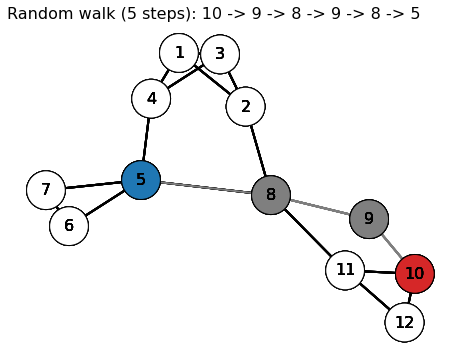

In [4]:
edge_list = [
    (1, 2),
    (1, 3),
    (1, 4),
    (2, 3),
    (2, 8),
    (3, 4),
    (4, 5),
    (5, 6),
    (5, 7),
    (5, 8),
    (6, 7),
    (8, 9),
    (8, 11),
    (9, 10),
    (10, 11),
    (10, 12),
    (11, 12),
]
G = nx.Graph(edge_list)
random_walk = RandomWalk(G)

plt.figure(figsize=(8, 6))
random_walk.run()
plt.show()